In [57]:
import numpy as np
import msprime
from IPython.display import SVG
import matplotlib.pyplot as plt

Total branch length: 2.5865135402851154


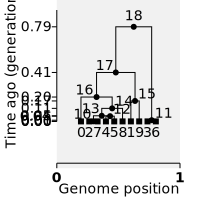

In [154]:
sample_size = 10
ts = msprime.sim_ancestry(sample_size, ploidy=1)
total_branch_length = sum([t.total_branch_length for t in ts.trees()])
print("Total branch length:", total_branch_length)
SVG(ts.draw_svg(y_axis=True))

In [58]:
def simulate(n_sample, n_population, rate, end_time, n_reps):
    n_mutations = []
    for _ in range(n_reps):
        ts = msprime.sim_ancestry(n_sample, population_size=n_population, ploidy=1, end_time=end_time)
        mts = msprime.sim_mutations(ts, rate=rate)
        n_mutations.append(mts.num_mutations)
    return np.mean(n_mutations), np.std(n_mutations)

n_sample = 100
n_population = 1000
rate = 100
end_time = 100
n_reps = 100
mean, std = simulate(n_sample, n_population, rate, end_time, n_reps)
print("Mean number of mutations:", mean)
print("Standard deviation of number of mutations:", std)

Mean number of mutations: 363564.11
Standard deviation of number of mutations: 23367.470659399576


In [66]:
n_sample = 100
n_population = 100

def total_branch_length(sample_size, population_size, n_reps, end_time=None):
    total_branch_lengths = []
    for _ in range(n_reps):
        ts = msprime.sim_ancestry(sample_size, population_size=population_size, ploidy=1, end_time=end_time)
        total_branch_length = 0
        for tree in ts.trees():
            total_branch_length += tree.total_branch_length
        total_branch_lengths.append(total_branch_length)
    assert len(total_branch_lengths) == n_reps
    return total_branch_lengths

def draw_tree(ts):
    return SVG(ts.draw_svg(node_labels={}, size=(400, 400), x_axis=False))

Fitted slope: 14.716673814701247
Fitted intercept: 87.04975613261631


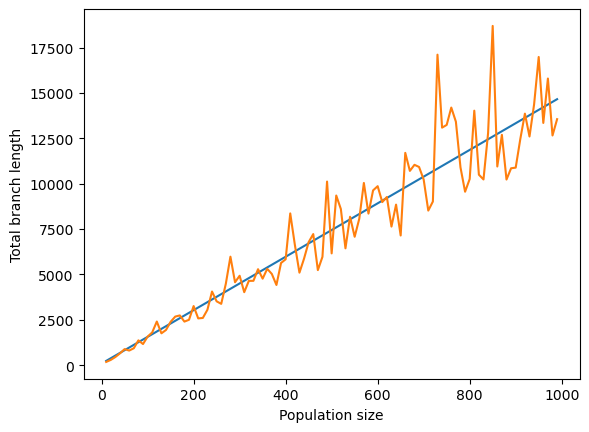

In [60]:
# plot total branch length as a function of population size
sample_size = 1000
n_reps = 100
population_sizes = np.arange(10, 1000, 10)
mean_branch_lengths = []
std_branch_lengths = []
for population_size in population_sizes:
    tbl = total_branch_length(sample_size, population_size, n_reps)
    mean = np.mean(tbl)
    std = np.std(tbl)
    mean_branch_lengths.append(mean)
    std_branch_lengths.append(std)

# fit linear model
A = np.vstack([population_sizes, np.ones(len(population_sizes))]).T
m, c = np.linalg.lstsq(A, mean_branch_lengths, rcond=None)[0]
print("Fitted slope:", m)
print("Fitted intercept:", c)

# plot

plt.plot(population_sizes, m * population_sizes + c, label="Fitted line")
plt.errorbar(population_sizes, mean_branch_lengths, yerr=std_branch_lengths)
plt.xlabel("Population size")
plt.ylabel("Total branch length")
plt.show()

Fitted slope: 2.026377488747911
Fitted intercept: 1.36845552282594


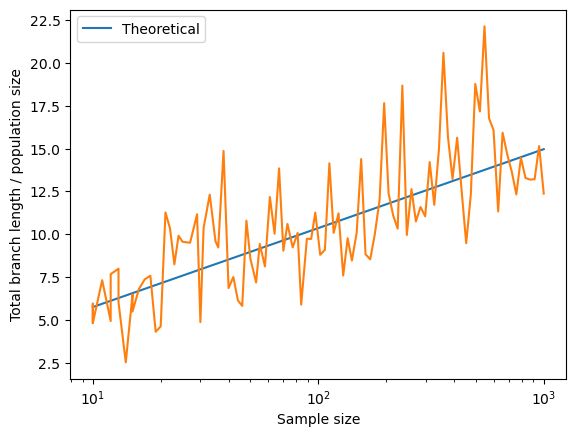

In [61]:
# plot total branch length as a function of sample size
population_size = 1
n_reps = 50
sample_sizes = np.logspace(1, 3, 100, dtype=int)
mean_branch_lengths = np.zeros(len(sample_sizes))
std_branch_lengths = np.zeros(len(sample_sizes))
for j, sample_size in enumerate(sample_sizes):
    tbl = total_branch_length(sample_size, population_size, n_reps)
    mean = np.mean(tbl)
    std = np.std(tbl)
    mean_branch_lengths[j] = mean
    std_branch_lengths[j] = std

# fit linear model
A = np.vstack([np.log(sample_sizes), np.ones(len(sample_sizes))]).T
m, c = np.linalg.lstsq(A, mean_branch_lengths, rcond=None)[0]
print("Fitted slope:", m)
print("Fitted intercept:", c)

# theoretical expression
# E(B) = 2 * (1 + 1/2 + 1/3 + ... + 1/(n-1)) = 2 * H_{n-1}
# H_n = 1 + 1/2 + 1/3 + ... + 1/n
# H_n = log(n) + gamma + 1/(2n) - 1/(12n^2) + O(1/n^4)

# plot theoretical expression
plt.plot(sample_sizes, 2 * np.log(sample_sizes) + 2 * 0.5772, label="Theoretical")

# plot
# plt.plot(sample_sizes, m * np.log(sample_sizes) + c, label="Fitted line")
plt.errorbar(sample_sizes, mean_branch_lengths, yerr=std_branch_lengths)
plt.xscale("log")
plt.xlabel("Sample size")
plt.ylabel("Total branch length / population size")

plt.legend()
plt.show()

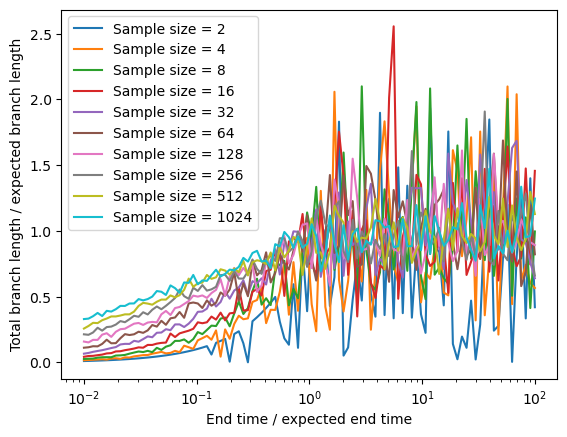

In [62]:
# Study how total branch length scales with end time
for sample_size in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    n_reps = 10
    expected_end_time = 2 * (1 - 1 / sample_size)
    expected_branch_length = 2 * sum(1 / i for i in range(1, sample_size))
    # end_times = np.linspace(0, 5 * expected_end_time, 100)
    # log end times to get a better spread, with expected end time in the middle
    end_times = np.logspace(-2, 2, 100) * expected_end_time
    mean_branch_lengths = np.zeros(len(end_times))
    std_branch_lengths = np.zeros(len(end_times))
    median_branch_lengths = np.zeros(len(end_times))
    for j, end_time in enumerate(end_times):
        tbl = total_branch_length(sample_size, population_size=1, n_reps=n_reps, end_time=end_time)
        mean = np.mean(tbl)
        std = np.std(tbl)
        median = np.median(tbl)
        mean_branch_lengths[j] = mean
        std_branch_lengths[j] = std
        median_branch_lengths[j] = median

    # normalize
    normalized_end_times = end_times / expected_end_time
    normalized_mean_branch_lengths = mean_branch_lengths / expected_branch_length
    normalized_std_branch_lengths = std_branch_lengths / expected_branch_length
    normalized_median_branch_lengths = median_branch_lengths / expected_branch_length

    # plot normalized branch length as a function of normalized end time using filled regions
    plt.plot(normalized_end_times, normalized_mean_branch_lengths, label="Sample size = {}".format(sample_size))
    plt.fill_between(normalized_end_times, normalized_mean_branch_lengths - normalized_std_branch_lengths, normalized_mean_branch_lengths + normalized_std_branch_lengths, alpha=0.3)

plt.xlabel("End time / expected end time")
plt.ylabel("Total branch length / expected branch length")
plt.xscale("log")
plt.legend()
plt.show()



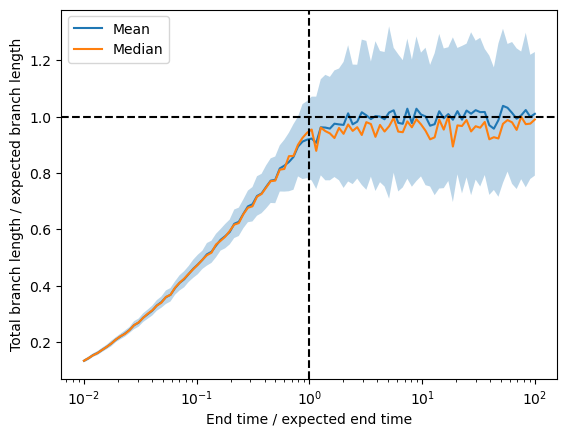

In [73]:
# Study how total branch length scales with end time
sample_size = 100
n_reps = 100
expected_end_time = 2 * (1 - 1 / sample_size)
expected_branch_length = 2 * sum(1 / i for i in range(1, sample_size))
# end_times = np.linspace(0, 5 * expected_end_time, 100)
# log end times to get a better spread, with expected end time in the middle
end_times = np.logspace(-2, 2, 100) * expected_end_time
mean_branch_lengths = np.zeros(len(end_times))
std_branch_lengths = np.zeros(len(end_times))
median_branch_lengths = np.zeros(len(end_times))
for j, end_time in enumerate(end_times):
    tbl = total_branch_length(sample_size, population_size=1, n_reps=n_reps, end_time=end_time)
    assert len(tbl) == n_reps
    mean = np.mean(tbl)
    std = np.std(tbl)
    median = np.median(tbl)
    mean_branch_lengths[j] = mean
    std_branch_lengths[j] = std
    median_branch_lengths[j] = median

# normalize
normalized_end_times = end_times / expected_end_time
normalized_mean_branch_lengths = mean_branch_lengths / expected_branch_length
normalized_std_branch_lengths = std_branch_lengths / expected_branch_length
normalized_median_branch_lengths = median_branch_lengths / expected_branch_length

# plot
plt.plot(normalized_end_times, normalized_mean_branch_lengths, label="Mean")
plt.fill_between(normalized_end_times, normalized_mean_branch_lengths - normalized_std_branch_lengths, normalized_mean_branch_lengths + normalized_std_branch_lengths, alpha=0.3)
plt.plot(normalized_end_times, normalized_median_branch_lengths, label="Median")

# horizontal line at 1
plt.axhline(1, color="black", linestyle="--")
# vertical line at 1
plt.axvline(1, color="black", linestyle="--")
plt.xlabel("End time / expected end time")
plt.ylabel("Total branch length / expected branch length")
plt.xscale("log")
plt.legend()
plt.show()

